In [ ]:
from dataclasses import dataclass
from fastai.vision.all import *
from fastai.vision.gan import *
from functools import partial
import gc
import itertools
import numpy as np 
import pandas as pd
from pathlib import Path
import seaborn as sns
import subprocess
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, Tuple, Union

In [2]:
run_as_standalone_nb = False

In [3]:
if run_as_standalone_nb:
    root_lib_path = Path('face2anime').resolve()
    if not root_lib_path.exists():
        !git clone https://github.com/davidleonfdez/face2anime.git
    if str(root_lib_path) not in sys.path:
        sys.path.insert(0, str(root_lib_path))
else:
    import local_lib_import

In [4]:
from face2anime.gen_utils import is_iterable
from face2anime.layers import (ConcatPoolHalfDownsamplingOp2d, ConvHalfDownsamplingOp2d, FeatureStatType, 
                               TransformsLayer, ParentNetSource, ResBlockDown)
from face2anime.losses import (ContentLossCallback, CritPredsTracker, CycleConsistencyLossCallback, 
                               CrossIdentityLossCallback, CycleGANLoss, IdentityLossCallback, LossWrapper, 
                               MultiCritPredsTracker, R1GANGPCallback)
from face2anime.misc import FeaturesCalculator
from face2anime.networks import (CycleCritic, CycleGenerator, default_decoder, default_encoder, Img2ImgGenerator, 
                                 PatchResCritic, patch_res_critic, res_critic)
from face2anime.train_utils import (add_ema_to_gan_learner, custom_load_model,
                                    custom_save_model)
from face2anime.transforms import AdaptiveAugmentsCallback, ADATransforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 64
save_cycle_len = 5

# Data

## Target ds

animecharacterfaces, by Kaggle user *aadilmalik94*

In [ ]:
anime_ds_path = Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data').resolve()

## Input ds

In [ ]:
celeba_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')
#input_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
input_a_fns = celeba_path.ls()
input_a_fns

The ds path passed to `dblock.dataloaders()` or `ImageDataLoaders.from_dblock()` will be forwarded
to `get_items`, which will return a list of items, usually a list of image paths if `get_items=get_image_files`.

So, for each item, we are expected to receive a filename `fn` and be able to
derive x and y from it, with `get_x(fn)` and `get_y(fn)`.

For bidirectional unpaired image to image translation, we can:
* Use the domain B ds path as the DataBlock `source`. 
* Load independently the filenames of the domain A ds; let's call it `input_a_fns`
* `get_y` needs two functions:
  * The first one can just return the path received (domain B).
  * The second returns a random item from `input_a_fns` (domain A).
* `get_x` also needs two functions:
  * The first one return a random item from `input_a_fns` (domain A).
  * The second can just return the path received (domain B).
* `get_x` and `get_y` are called every time a data item is used; so, by using random, we can be sure every x is not tied to a fixed y; i.e., they won't be together in the same (x, y) batch every epoch for loss calculation.
* In this case, domain A: human faces; domain B: anime faces.


---

In [ ]:
def reverse_domain(domain): return "B" if domain == "A" else "A"


def get_random_fn_a(fn):
    return input_a_fns[random.randint(0, len(input_a_fns)-1)]


normalize_tf = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))


def get_dblock(extra_batch_tfms=None):
    if extra_batch_tfms is None: extra_batch_tfms = []    
    return DataBlock(blocks=(ImageBlock, ImageBlock, ImageBlock, ImageBlock),
                     get_x=[get_random_fn_a, noop],
                     get_y=[noop, get_random_fn_a],
                     get_items=get_image_files,
                     #get_items=lambda path: target_fns,
                     splitter=IndexSplitter([]),
                     item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                     batch_tfms=[normalize_tf] + extra_batch_tfms,
                     n_inp=2)


dblock = get_dblock()
main_path = anime_ds_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

In [ ]:
# It doesn't work for now
# dls.show_batch()

In [ ]:
sample_batch = dls.one_batch()
titles = ['x1 (A)', 'x2 (B)', 'y1 (B)', 'y2 (A)']
_, axs = plt.subplots(1, 4)
for t, ax, title in zip(sample_batch, axs, titles):
    normalize_tf.decode(t)[0].show(ax=ax, title=title)

# Loss function utils

In [ ]:
vgg_content_layers_idx = [22]
ftrs_calc = FeaturesCalculator([], vgg_content_layers_idx, device=device,
                               input_norm_tf=normalize_tf)

------------------

# Training

In [ ]:
def clean_mem():
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()


def predict_n(learner, inputs_idxs:Union[int, Tuple[int, int]], max_bs=64):
    dummy_path = Path('.')
    items = learner.dls.train.items
    if isinstance(inputs_idxs, int):
        n_imgs = inputs_idxs
        ini_idx = 0
        end_idx = n_imgs
    else:
        ini_idx, end_idx = inputs_idxs
        n_imgs = end_idx - ini_idx
    if len(items) < end_idx: items = list(itertools.islice(itertools.cycle(items), ini_idx, end_idx))
    dl = learner.dls.test_dl(items[:n_imgs], bs=max_bs)   
    inp, _, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch(inp + dec_imgs_t, max_n=n_imgs)
    return dec_batch


def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 4, figsize=(12, n_imgs * 3))
    for i, (in_a, in_b, pred_a2b, pred_b2a) in enumerate(preds_batch):
        in_a.show(ax=axs[i][0], title='In A')
        pred_a2b.show(ax=axs[i][1], title='Out A->B')
        in_b.show(ax=axs[i][2], title='In B')
        pred_b2a.show(ax=axs[i][3], title='Out B->A')

        
class SaveCheckpointsCallback(Callback):
    "Callback that saves the model at the end of each epoch."
    def __init__(self, fn_prefix, base_path=Path('.'), initial_epoch=1,
                 save_cycle_len=1):
        self.fn_prefix = fn_prefix
        self.base_path = base_path
        self.epoch = initial_epoch
        self.save_cycle_len = save_cycle_len
        
    def after_epoch(self):
        if (self.epoch % self.save_cycle_len) == 0:
            fn = f'{self.fn_prefix}_{self.epoch}ep'
            custom_save_model(self.learn, fn, base_path=self.base_path)
        self.epoch += 1
        
        
def save_preds(c_preds_tracker, filepaths):
    return [df.to_csv(filepath) for df, filepath in zip(c_preds_tracker.to_dfs(), filepaths)]
        
    
def plot_c_preds(c_preds_tracker):
    preds_xs = range(len(c_preds_tracker.real_preds))
    sns.lineplot(x=preds_xs, y=c_preds_tracker.fake_preds.cpu(), label='Fake preds')
    ax=sns.lineplot(x=preds_xs, y=c_preds_tracker.real_preds.cpu(), label='Real preds')
    ax.set_xlabel('Number of batches')
    ax.set_ylabel('Critic preds')
    return ax


def plot_multi_c_preds(multi_c_preds_tracker, titles):
    axs = []
    for c_preds_tracker, title in zip(multi_c_preds_tracker.trackers, titles):
        ax=plot_c_preds(c_preds_tracker)
        axs.append(ax)
        plt.legend(title=title)
        plt.figure()
    return axs

In [ ]:
def _forward_batch(model, batch, device):
    input = batch[:2]
    if device is not None:
        for i in range(2): input[i] = input[i].to(device)
    model(*input)


def create_learner(for_inference=False, dblock=dblock, dls=dls, gp_w=10., latent_sz=100, 
                   mid_mlp_depth=2, g_norm=NormType.Instance, n_crit_iters=3,
                   n_extra_convs_by_c_res_block=1, cycle_cons_w=0, id_loss_w=0, 
                   cross_id_loss_w=0, use_patch_critic=False, patch_c_cls=patch_res_critic, 
                   ftrs_stats=FeatureStatType.NONE, ftrs_stats_source=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    crit_args = [img_size, n_channels, down_op, id_down_op]
    if use_patch_critic: crit_args.insert(2, img_size//8)
    crit_kwargs = dict(n_extra_convs_by_res_block=n_extra_convs_by_c_res_block, 
                       act_cls=leakyReLU02, bn_1st=False, n_features=128, 
                       flatten_full=True)
    if use_patch_critic and (ftrs_stats != FeatureStatType.NONE):
        patch_c_cls = PatchResCritic
        crit_kwargs['ftrs_stats'] = ftrs_stats
        crit_kwargs['ftrs_stats_source'] = ftrs_stats_source
        crit_kwargs['input_norm_tf'] = normalize_tf
        crit_kwargs['device'] = device
    crit_builder = patch_c_cls if use_patch_critic else res_critic  
    base_critics = [crit_builder(*crit_args, **crit_kwargs) for _ in range(2)]
    base_critics = CycleCritic(*base_critics)
    critic = base_critics
    
    def _decoder_builder(imsz, nch, latsz, hooks_by_sz=None): 
        return default_decoder(imsz, nch, latsz, norm_type=g_norm, hooks_by_sz=hooks_by_sz)
    generators = [Img2ImgGenerator(img_size, n_channels, mid_mlp_depth=mid_mlp_depth, skip_connect=True,
                                   encoder=default_encoder(img_size, n_channels, latent_sz, norm_type=g_norm),
                                   decoder_builder=_decoder_builder)
                  for _ in range(2)]
    generator = CycleGenerator(*generators)
    
    cbs = []
    c_loss_interceptors = []
    metrics = []
    if not for_inference:
        # Pass base_critic to avoid grid_sample 2nd order derivative issue with ada critic
        cbs.append(R1GANGPCallback(weight=gp_w, critic=base_critics))
        if cycle_cons_w > 0: 
            cbs.append(CycleConsistencyLossCallback(generator.g_a2b, 
                                                    generator.g_b2a, 
                                                    weight=cycle_cons_w))
            metrics.append('cycle_loss')
        if id_loss_w > 0:
            cbs.append(IdentityLossCallback(generator.g_a2b, 
                                            generator.g_b2a, 
                                            weight=id_loss_w))
            metrics.append('identity_loss')
        if cross_id_loss_w > 0:
            cbs.append(CrossIdentityLossCallback(generator.g_a2b, 
                                                 generator.g_b2a, 
                                                 weight=cross_id_loss_w))
            metrics.append('cross_identity_loss')
        overall_crit_preds_tracker = MultiCritPredsTracker(reduce_batch=True)
        c_loss_interceptors.append(overall_crit_preds_tracker)
        
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=n_crit_iters, n_gen=1),
                       switch_eval=False, metrics=LossMetrics(metrics) or None)
    learn.loss_func = CycleGANLoss(learn.loss_func)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, decay=0.999, forward_batch=_forward_batch)
    if not for_inference: learn.crit_preds_tracker = overall_crit_preds_tracker
    return learn

## TR 1: SN+BN critic, BN+SN gen (both encoder and decoder), no extra losses

In [ ]:
def create_learner_1(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Batch)

In [ ]:
learn = create_learner_1()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr1', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.model.critic, learn.model.generator

In [ ]:
# custom_load_model(learn, 'face2anime_bidir_tr1_50ep', base_path='./models', with_ema=True)
# #preds_df = pd.read_csv(io.StringIO(preds_csv_str), index_col=0)
# #learn.crit_preds_tracker.load_from_df(preds_df, device)
# with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
#     displayable_learn.show_results(ds_idx=0)

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr1_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr1_200ep.csv')])

## TR 2: SN+BN critic, BN+SN gen (both encoder and decoder), cycle consistency loss, identity loss

### 2a: global critic

In [ ]:
def create_learner_2(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Batch, 
                          cycle_cons_w=1., id_loss_w=1.)

In [ ]:
learn = create_learner_2()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints]) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2_200ep.csv')])

### 2b: patch critic

In [ ]:
def create_learner_2b(*args, **kwargs):
    return create_learner_2(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_2b()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2b', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2b_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2b_200ep.csv')])

### TR 2c: patch critic, tfms = {Flip, Warp, Zoom}

In [ ]:
def create_learner_2c(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), Warp(p=0.5), Zoom(p=0.5, max_zoom=1.1)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)    
    
    return create_learner_2(*args, **kwargs, for_inference=for_inference, dblock=aug_dblock, 
                            dls=aug_dls, use_patch_critic=True, n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_2c()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2c', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2c_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2c_200ep.csv')])

### Tr 2f: patch critic with Mean stats of pretrained vgg features

In [ ]:
def create_learner_2f(*args, **kwargs):
    return create_learner_2(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN)

In [ ]:
learn = create_learner_2f()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2f', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2f_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2f_200ep.csv')])

### Tr 2h: patch critic with Mean and Correlations stats of pretrained vgg features

In [ ]:
def create_learner_2h(*args, **kwargs):
    return create_learner_2(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN | FeatureStatType.CORRELATIONS)

In [ ]:
learn = create_learner_2h(dls = dblock.dataloaders(main_path, path=main_path, bs=48))
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2h', initial_epoch=101,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
axs = plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])
for ax in axs: ax.set_ybound(-10, 10)

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2h_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2h_200ep.csv')])

### Tr 2i: patch critic with Mean, Std and Correlations stats of its own features

In [ ]:
def create_learner_2i(*args, **kwargs):
    ftr_stats_source = ParentNetSource(layer_types=(ResBlock, ResBlockDown))
    return create_learner_2(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN | FeatureStatType.STD | FeatureStatType.CORRELATIONS,
                            ftrs_stats_source=ftr_stats_source)

In [ ]:
learn = create_learner_2i()#dls = dblock.dataloaders(main_path, path=main_path, bs=48))
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2i', initial_epoch=121,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
axs = plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])
for ax in axs: ax.set_ybound(-10, 10)

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2i_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2i_200ep.csv')])

### 2j [2h + tfms]:  patch critic with Mean and Correlations stats for pretrained vgg features, tfms={Flip, DiscriminativeRotate}

In [ ]:
class DiscriminativeRotate(Rotate):
    def __init__(self, *args, batch_idxs=None, **kwargs):
        self.batch_idxs = batch_idxs
        super().__init__(*args, **kwargs)
    
    def _do_call(self, f, x, **kwargs):
        # TODO: overriding THIS IS HACKY and potentially unstable
        if not isinstance(x, tuple):
            if f is None: return x
            ret = f.returns_none(x) if hasattr(f,'returns_none') else None
            return retain_type(f(x, **kwargs), x, ret)
        batch_idxs = ifnone(self.batch_idxs, range(len(x)))
        res = tuple((self._do_call(f, x_, **kwargs) if i in batch_idxs else x_)
                    for i, x_ in enumerate(x))
        return retain_type(res, x)

In [ ]:
def create_learner_2j(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), DiscriminativeRotate(p=0.8, batch_idxs=[0, 3], max_deg=30)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=48) #bs<64 maybe needed
    return create_learner_2(*args, **kwargs, for_inference=for_inference, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN | FeatureStatType.CORRELATIONS,
                            dblock=aug_dblock, dls=aug_dls)

In [ ]:
learn = create_learner_2j()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr2j', initial_epoch=321,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

Let's check if Rotate is applied only to human faces:

In [ ]:
tmp_b = normalize_tf.decode(learn.dls.one_batch())
for i in range(4): tmp_b[i][0].show()

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
axs = plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])
for ax in axs: ax.set_ybound(-10, 10)

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr2j_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr2j_200ep.csv')])

## TR 3: SN+BN critic, IN+SN gen (both encoder and decoder), cycle consistency loss, identity loss

In [ ]:
def create_learner_3(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Instance, 
                          cycle_cons_w=1., id_loss_w=1.)

### Tr 3b: patch critic

In [ ]:
def create_learner_3b(*args, **kwargs):
    return create_learner_3(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_3b()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3b', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3b_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3b_200ep.csv')])

### TR 3c: patch critic, tfms = {Flip, Warp, Zoom}

In [ ]:
def create_learner_3c(*args, for_inference=False, **kwargs):
    extra_tfms = [Flip(p=0.5), Warp(p=0.5), Zoom(p=0.5, max_zoom=1.1)] if not for_inference else []
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)    
    
    return create_learner_3(*args, **kwargs, for_inference=for_inference, dblock=aug_dblock, 
                            dls=aug_dls, use_patch_critic=True, n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_3c()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3c', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3c_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3c_200ep.csv')])

### TR 3d: patch critic, tfms = {Flip, Warp, Zoom, Rotate}

In [ ]:
def create_learner_3d(*args, for_inference=False, **kwargs):
    extra_tfms = ([Flip(p=0.5), Warp(p=0.5), Zoom(p=0.5, max_zoom=1.1), Rotate(p=0.6, max_deg=30)] 
                 if not for_inference 
                 else [])
    aug_dblock = get_dblock(extra_batch_tfms=extra_tfms)
    aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)    
    
    return create_learner_3(*args, **kwargs, for_inference=for_inference, dblock=aug_dblock, 
                            dls=aug_dls, use_patch_critic=True, n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_3d()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3d', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3d_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3d_200ep.csv')])

### Tr 3e: patch critic w/o pooling layers in encoder

In [ ]:
def create_learner_3e(*args, **kwargs):
    return create_learner_3(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            encoder_builder=basic_encoder)

### Tr 3f: patch critic with Mean stats of pretrained vgg features

In [ ]:
def create_learner_3f(*args, **kwargs):
    return create_learner_3(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftr_stats=FeatureStatType.MEAN)

In [ ]:
learn = create_learner_3f()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3f', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3f_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3f_200ep.csv')])

### Tr 3g: patch critic with Mean and Std stats of its own features

In [ ]:
def create_learner_3g(*args, **kwargs):
    ftr_stats_source = ParentNetSource(layer_types=(ResBlock, ResBlockDown))
    return create_learner_3(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN | FeatureStatType.STD,
                            ftrs_stats_source=ftr_stats_source)

In [ ]:
learn = create_learner_3g()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3g', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3g_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3g_200ep.csv')])

### Tr 3h: patch critic with Mean and Correlations stats of pretrained vgg features

In [ ]:
def create_learner_3h(*args, **kwargs):
    return create_learner_3(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0,
                            ftrs_stats=FeatureStatType.MEAN | FeatureStatType.CORRELATIONS)

In [ ]:
learn = create_learner_3h()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr3h', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr3h_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr3h_200ep.csv')])

## TR 4: SN+BN critic, IN+SN gen (both encoder and decoder), cycle consistency loss, cross identity loss

In [ ]:
def create_learner_4(*args, **kwargs):
    return create_learner(*args, **kwargs, gp_w=10., g_norm=NormType.Instance, 
                          cycle_cons_w=1., cross_id_loss_w=1.)

### Tr 4b: patch critic

In [ ]:
def create_learner_4b(*args, **kwargs):
    return create_learner_4(*args, **kwargs, use_patch_critic=True, 
                            n_extra_convs_by_c_res_block=0)

In [ ]:
learn = create_learner_4b()
learn.add_cb(SaveCheckpointsCallback('face2anime_bidir_tr4b', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
cbs_to_remove_for_display = [learn.save_checkpoints, 
                             learn.cycle_consistency_loss, 
                             learn.cross_identity_loss]
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs(cbs_to_remove_for_display) as displayable_learn:
    predict_show_n(displayable_learn, 6)

In [ ]:
predict_show_n(ema_g_learn, 6)

In [ ]:
plot_multi_c_preds(learn.crit_preds_tracker, ['A->B', 'B->A'])

In [ ]:
save_preds(learn.crit_preds_tracker, 
           [Path('crit_preds_face2anime_bidir_a2b_tr4b_200ep.csv'),
            Path('crit_preds_face2anime_bidir_b2a_tr4b_200ep.csv')])

# Evaluation results

In [7]:
model_descriptions = {
    '2': 'BN G',
    '2b': 'BN G, patch C',
    '2c': 'BN G, patch C, ds tfms: {Flip, Warp, Zoom}', 
    '2f': 'BN G, patch C + MeanPretrainedFeatures', 
    '2h': 'BN G, patch C + MeanCorrelationsPretrainedFeatures', 
    '2i': 'BN G, patch C + MeanStdCorrelationsCriticFeatures', 
    '2j': 'BN G, patch C + MeanCorrelationsPretrainedFeatures, ds tfms: {Flip, Disc Rotate}', 
    '3b': 'IN G, patch C', 
    '3c': 'IN G, patch C, ds tfms: {Flip, Warp, Zoom}',
    '3d': 'IN G, patch C, ds tfms: {Flip, Warp, Zoom, Rotate}',
    '3e': 'IN G, patch C w/o pooling layers in encoder', 
    '3f': 'IN G, patch C + MeanPretrainedFeatures', 
    '3g': 'IN G, patch C + MeanStdCriticFeatures',
    '4b': 'IN G + cross id loss, patch C', 
}   

In [8]:
def fids_arr_to_dict(fids_arr, initial_ep=save_cycle_len, n_ep_by_fid=save_cycle_len):
    end_ep = initial_ep + n_ep_by_fid*len(fids_arr)
    return {ep: fid for fid, ep in zip(fids_arr, range(initial_ep, end_ep, n_ep_by_fid))}


def plot_fids_vs_epochs(fids_dict, **lineplot_kwargs):
    x = fids_dict.keys()
    y = fids_dict.values()
    ax = sns.lineplot(x=x, y=y, **lineplot_kwargs)
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('FID')
    return ax


def plot_fids_vs_inputs_targets(epoch, domain, use_ema_models=True, ids_excluded=None):
    assert domain in ('A', 'B')
    tf = 'a2b' if domain == 'B' else 'b2a'
    ema_str = 'ema_' if use_ema_models else ''
    if ids_excluded is None: ids_excluded = []
    tr_ids = [k for k in model_descriptions.keys() if k not in ids_excluded]
    xs = [globals()[f'fids_trans_tr{tr_id}_{tf}_{ema_str}dict'][epoch] for tr_id in tr_ids]
    ys = [globals()[f'fids_tr{tr_id}_{tf}_{ema_str}dict'][epoch] for tr_id in tr_ids]
    #hues = model_descriptions.values()
    hues = [model_descriptions[k] for k in tr_ids]
    
    ax = sns.scatterplot(x=xs, y=ys, hue=hues)
    ax.set_xlabel('FID fakes vs inputs (translation)')
    ax.set_ylabel('FID fakes vs targets')
    tf_str = f'{reverse_domain(domain)}->{domain}'
    ema_title_str = 'EMA ' if use_ema_models else ''
    title = f'Compared FIDs of {ema_title_str}models for transformation {tf_str} after {epoch} epochs'
    ax.set_title(title)
    return ax

In [9]:
##########################################################################
###### FAKE vs REAL targets ##############################################
##########################################################################
fids_tr2_a2b = [75.7, 68.5, 86.4, 75.3, 83.2, 79.0, 
                82.9, 79.2, 81.9, 90.1, 91.8, 82.9, 61.3, 81.2, 81.5, 74.7,
                75.9, 91.2, 83.2, 99.5, 104.4, 96.8, 109.0, 109.1, 102.5, 119.1,
                118.4, 128.3, 100.0, 90.3, 115.3, 125.2, 119.8, 104.3, 120.0, 93.2]
fids_tr2_a2b_dict = fids_arr_to_dict(fids_tr2_a2b, initial_ep=25)
fids_tr2_a2b_ema_dict = {40: 108.1, 60: 49.1, 70: 39.5, 80: 34.7, 90: 31.9, 100: 31.1,
                         110: 30.5, 120: 30.9, 130: 31.6, 140: 31.4, 150: 30.6,
                         160: 30.3, 170: 30.7, 180: 31.0, 190: 32.7, 200: 33.0}
fids_tr2_b2a = [50.2, 39.5, 47.4, 35.1, 40.4, 39.6, 
                39.5, 46.9, 41.4, 41.9, 42.4, 57.9, 54.9, 48.6, 58.1, 49.6,
                68.9, 50.0, 70.4, 74.2, 65.0, 62.7, 48.0, 75.1, 73.4, 56.4,
                64.5, 83.9, 99.4, 62.5, 61.7, 80.7, 94.3, 82.4, 107.1, 97.2]
fids_tr2_b2a_dict = fids_arr_to_dict(fids_tr2_b2a, initial_ep=25)
fids_tr2_b2a_ema_dict = {40: 28.0, 60: 16.5, 70: 14.4, 80: 13.1, 90: 12.2, 100: 11.3,
                         110: 10.8, 120: 10.2, 130: 9.7, 140: 9.4, 150: 9.0,
                         160: 8.7, 170: 8.5, 180: 8.6, 190: 8.3, 200: 8.3}

# 25-200 ep
fids_tr2b_a2b = [99.0, 85.0, 91.9, 73.7, 80.5, 75.4, 
                 72.3, 79.9, 71.6, 84.6, 87.1, 71.5, 72.4, 73.2, 69.3, 79.8,
                 74.0, 83.3, 69.6, 40.9, 57.9, 84.8, 76.7, 83.1, 80.0, 87.1, 
                 82.4, 92.4, 111.7, 102.0, 89.7, 103.5, 110.3, 116.5, 93.5, 95.6]
fids_tr2b_a2b_dict = fids_arr_to_dict(fids_tr2b_a2b, initial_ep=25)
fids_tr2b_a2b_ema_dict = {40: 79.5, 60: 36.0, 70: 27.6, 80: 23.2, 90: 19.7, 100: 18.5,
                          110: 18.7, 120: 18.1, 130: 17.6, 140: 17.4, 150: 17.3,
                          160: 17.2, 170: 16.8, 180: 16.4, 190: 16.8, 200: 16.2}
# 25-200 ep
fids_tr2b_b2a = [77.8, 75.4, 82.0, 81.9, 76.8, 80.3,
                 81.4, 77.3, 80.8, 84.1, 75.5, 81.6, 88.2, 84.4, 107.5, 79.5,
                 69.8, 67.6, 77.2, 83.0, 86.1, 85.9, 77.2, 89.7, 77.8, 83.6, 
                 90.0, 100.6, 92.3, 101.6, 95.4, 107.7, 106.9, 99.9, 101.8, 96.9]
fids_tr2b_b2a_dict = fids_arr_to_dict(fids_tr2b_b2a, initial_ep=25)
fids_tr2b_b2a_ema_dict = {40: 33.0, 60: 21.1, 70: 18.4, 80: 16.7, 90: 15.3, 100: 14.2,
                          110: 13.4, 120: 12.7, 130: 12.3, 140: 11.7, 150: 11.0,
                          160: 10.5, 170: 10.0, 180: 10.1, 190: 9.3, 200: 9.2}

# 25-200ep
fids_tr2c_a2b = [103.1, 100.9, 101.5, 92.1, 83.1, 90.0,
                 74.1, 75.3, 78.1, 86.2, 76.4, 79.4, 71.6, 82.5, 93.1, 66.2,
                 95.2, 92.9, 101.1, 83.5, 95.9, 99.0, 89.1, 96.7, 99.7, 102.7,
                 101.7, 111.2, 102.9, 103.6, 111.2, 120.2, 126.4, 123.3, 119.0, 110.8]
fids_tr2c_a2b_dict = fids_arr_to_dict(fids_tr2c_a2b, initial_ep=25)
fids_tr2c_a2b_ema_dict = {40: 90.5, 60: 53.2, 70: 41.9, 80: 35.3, 90: 32.7, 100: 29.5,
                          110: 31.2, 120: 26.2, 130: 25.2, 140: 25.1, 150: 23.7,
                          160: 23.6, 170: 23.7, 180: 23.2, 190: 23.7, 200: 24.3}
# 25-200ep
fids_tr2c_b2a = [70.9, 66.2, 57.3, 65.6, 68.3, 75.3,
                 60.7, 71.6, 63.6, 69.3, 67.4, 53.3, 78.4, 68.1, 71.3, 68.9,
                 71.0, 62.9, 92.0, 55.0, 54.1, 55.4, 56.7, 61.8, 54.1, 59.0,
                 61.9, 62.8, 58.3, 74.1, 64.0, 58.6, 61.2, 67.5, 68.3, 68.0]
fids_tr2c_b2a_dict = fids_arr_to_dict(fids_tr2c_b2a, initial_ep=25)
fids_tr2c_b2a_ema_dict = {40: 45.0, 60: 24.9, 70: 20.8, 80: 18.2, 90: 16.0, 100: 14.7,
                          110: 14.2, 120: 13.9, 130: 13.0, 140: 12.6, 150: 11.7,
                          160: 11.3, 170: 11.0, 180: 10.8, 190: 11.0, 200: 10.2}

fids_tr2f_a2b = [77.3, 67.9, 71.8, 74.6, 81.5, 71.8, 94.5, 66.6, 75.2, 95.5, 
                 76.9, 87.5, 68.4, 84.9, 102.7, 113.8, 98.6, 101.3, 102.3, 98.8,
                 90.9, 106.2, 98.6, 118.2, 93.6, 98.4, 109.1, 119.8, 104.0, 119.9, 
                 118.0, 116.8, 127.3, 125.7, 133.1, 132.2, 107.2, 103.9, 119.1, 141.7]
fids_tr2f_a2b_dict = fids_arr_to_dict(fids_tr2f_a2b)
fids_tr2f_a2b_ema_dict = {40: 32.7, 60: 19.9, 80: 17.1, 100: 16.0,
                          120: 16.1, 140: 15.5, 160: 14.9, 180: 14.2, 200: 14.5,
                          220: 14.7, 230: 14.1}
fids_tr2f_b2a = [70.3, 47.8, 67.5, 64.2, 86.5, 64.8, 74.9, 76.1, 85.3, 78.4, 
                 85.0, 87.9, 69.1, 87.7, 85.5, 95.2, 90.1, 94.1, 68.2, 88.0,
                 92.7, 95.7, 94.2, 94.1, 88.1, 91.2, 92.5, 94.9, 83.4, 85.1, 
                 101.1, 87.5, 99.5, 86.3, 97.9, 87.1, 100.5, 93.9, 95.7, 95.5]
fids_tr2f_b2a_dict = fids_arr_to_dict(fids_tr2f_b2a)
fids_tr2f_b2a_ema_dict = {40: 29.6, 60: 21.4, 80: 17.2, 100: 14.6,
                          120: 12.4, 140: 10.9, 160: 10.4, 180: 9.7, 200: 9.4,
                          220: 9.1, 230: 9.0}

fids_tr2h_a2b = [74.6, 159.2, 77.8, 74.3, 85.1, 78.6, 
                 91.3, 77.7, 90.4, 71.4, 93.7, 94.0, 102.2, 99.3, 107.9, 117.1,
                 120.6, 102.9, 104.9, 115.6, 100.5, 127.9, 126.7, 120.1, 141.8, 133.7, 
                 120.9, 126.5, 125.1, 126.7, 131.0, 141.3, 133.4, 144.0, 125.0, 142.4]
fids_tr2h_a2b_dict = fids_arr_to_dict(fids_tr2h_a2b, initial_ep=25)
fids_tr2h_a2b_ema_dict = {40: 26.4, 60: 17.7, 80: 16.1, 100: 15.5,
                          120: 15.1, 140: 14.6, 160: 15.0, 180: 15.8, 200: 14.8}
fids_tr2h_b2a = [80.6, 139.9, 103.8, 106.2, 106.2, 119.7, 
                 108.7, 109.1, 127.5, 120.7, 126.0, 130.4, 120.6, 117.1, 125.3, 125.6,
                 124.2, 127.4, 115.4, 129.1, 124.0, 126.4, 138.6, 125.4, 130.7, 126.8, 
                 124.6, 124.6, 122.6, 130.4, 92.1, 120.3, 126.4, 122.2, 121.6, 127.8]
fids_tr2h_b2a_dict = fids_arr_to_dict(fids_tr2h_b2a, initial_ep=25)
fids_tr2h_b2a_ema_dict = {40: 21.4, 60: 15.8, 80: 12.8, 100: 10.6,
                          120: 9.9, 140: 9.0, 160: 8.9, 180: 9.6, 200: 8.9}

fids_tr2i_a2b = [104.9, 107.2, 100.6, 87.2, 75.7, 64.0, 
                 80.1, 76.1, 79.5, 71.9, 90.3, 83.0, 84.8, 74.2, 85.4, 77.8, 
                 58.4, 83.2, 79.6, 86.6, 99.3, 102.9, 91.8, 107.5, 122.3, 100.7, 
                 102.8, 119.3, 101.2, 107.0, 110.5, 100.2, 123.4, 103.7, 101.6, 124.9]
fids_tr2i_a2b_dict = fids_arr_to_dict(fids_tr2i_a2b, initial_ep=25)
fids_tr2i_a2b_ema_dict = {40: 89.8, 60: 45.0, 80: 26.4, 100: 20.5,
                          120: 18.2, 140: 17.8, 160: 17.3, 180: 17.1, 200: 16.8}
fids_tr2i_b2a = [89.6, 89.6, 96.7, 74.1, 75.3, 70.3, 
                 74.7, 77.2, 91.1, 93.5, 88.6, 83.1, 116.5, 70.8, 67.3, 76.2, 
                 53.7, 62.6, 75.2, 57.8, 68.4, 68.6, 90.0, 38.9, 76.2, 77.0, 
                 69.3, 91.9, 88.5, 82.1, 68.9, 90.9, 90.4, 62.5, 91.7, 96.2]
fids_tr2i_b2a_dict = fids_arr_to_dict(fids_tr2i_b2a, initial_ep=25)
fids_tr2i_b2a_ema_dict = {40: 32.7, 60: 19.6, 80: 15.1, 100: 12.2,
                          120: 11.0, 140: 10.5, 160: 9.7, 180: 9.2, 200: 8.9}

fids_tr2j_a2b_dict = {25: 75.5, 30: 74.8, 35: 94.1, 40: 97.5, 45: 96.5, 50: 93.8, 
                      55: 114.2, 60: 121.4, 65: 105.0, 70: 124.8, 75: 125.5, 80: 106.9, 100: 122.0, 
                      150: 157.5, 200: 160.3}
fids_tr2j_a2b_ema_dict = {40: 26.9, 60: 20.0, 80: 18.4, 100: 17.5,
                          120: 16.3, 140: 16.4, 160: 15.0, 180: 15.6, 200: 15.1,
                          210: 14.5, 220: 15.2, 230: 17.4, 240: 13.6, 250: 13.9,
                          260: 14.0, 270: 15.6, 280: 15.5, 290: 15.2, 300: 14.8,
                          310: 14.3, 320: 13.7, 330: 13.7, 340: 14.0, 350: 14.1, 
                          360: 14.0, 370: 14.0, 380: 14.4, 390: 14.4, 400: 14.2}
fids_tr2j_b2a_dict = {25: 79.7, 30: 88.4, 35: 132.2, 40: 88.0, 45: 99.3, 50: 73.5, 
                      55: 97.6, 60: 101.4, 65: 90.0, 70: 83.0, 75: 121.5, 80: 120.2, 100: 102.9, 
                      150: 127.8, 200: 119.5}
fids_tr2j_b2a_ema_dict = {40: 35.8, 60: 24.0, 80: 19.9, 100: 18.9,
                          120: 17.6, 140: 16.9, 160: 16.8, 180: 14.9, 200: 14.4,
                          210: 14.5, 220: 13.8, 230: 14.0, 240: 13.7, 250: 13.5,
                          260: 14.3, 270: 14.3, 280: 13.1, 290: 12.8, 300: 13.3,
                          310: 13.4, 320: 13.0, 330: 13.0, 340: 13.0, 350: 12.9, 
                          360: 12.7, 370: 12.8, 380: 12.9, 390: 12.7, 400: 12.6}


fids_tr3b_a2b = [103.4, 83.2, 74.2, 74.7, 53.8, 51.5, 
                 45.8, 46.7, 46.6, 44.5, 42.9, 49.0, 36.5, 38.2, 35.7, 32.9,
                 34.1, 35.3, 34.3, 32.0, 30.4, 33.4, 34.2, 31.6, 28.8, 34.4,
                 30.9, 26.4, 31.7, 32.3, 32.3, 24.9, 29.2, 32.0, 33.0, 28.6]
fids_tr3b_a2b_dict = fids_arr_to_dict(fids_tr3b_a2b, initial_ep=25)
fids_tr3b_a2b_ema_dict = {40: 144.3, 60: 78.7, 70: 61.0, 80: 51.1, 90: 42.5, 100: 36.1,
                          110: 33.5, 120: 31.4, 130: 28.2, 140: 26.6, 150: 25.5,
                          160: 24.7, 170: 23.8, 180: 23.0, 190: 22.5, 200: 21.8}
fids_tr3b_b2a = [60.5, 52.8, 51.8, 43.4, 42.6, 34.7, 
                 36.2, 33.3, 33.2, 29.3, 29.2, 31.3, 34.0, 31.4, 49.2, 30.6,
                 31.0, 29.2, 28.3, 33.1, 27.9, 26.7, 26.5, 25.4, 25.2, 20.3,
                 32.7, 31.7, 20.4, 25.2, 20.1, 29.1, 24.3, 17.4, 16.8, 20.8]
fids_tr3b_b2a_dict = fids_arr_to_dict(fids_tr3b_b2a, initial_ep=25)
fids_tr3b_b2a_ema_dict = {40: 61.4, 60: 31.7, 70: 27.2, 80: 24.9, 90: 23.0, 100: 21.3,
                          110: 19.7, 120: 18.1, 130: 17.2, 140: 16.4, 150: 15.6,
                          160: 14.6, 170: 13.9, 180: 13.3, 190: 12.8, 200: 12.4}

fids_tr3c_a2b = [121.6, 108.0, 91.9, 93.3, 83.5, 76.2, 
                 70.2, 52.7, 66.1, 61.2, 63.3, 56.9, 50.6, 65.6, 61.6, 50.3,
                 51.9, 47.2, 50.9, 57.2, 50.9, 52.6, 47.0, 41.7, 41.6, 38.8,
                 48.1, 37.6, 48.0, 50.5, 40.5, 40.5, 46.7, 53.8, 39.0, 50.4]
fids_tr3c_a2b_dict = fids_arr_to_dict(fids_tr3c_a2b, initial_ep=25)
fids_tr3c_a2b_ema_dict = {40: 152.7, 60: 108.4, 70: 89.6, 80: 73.7, 90: 64.2, 100: 58.3,
                          110: 53.0, 120: 49.9, 130: 46.5, 140: 43.8, 150: 41.8,
                          160: 38.7, 170: 37.2, 180: 35.0, 190: 33.9, 200: 34.2}
fids_tr3c_b2a = [75.5, 61.6, 54.2, 51.7, 48.9, 43.0, 
                 44.0, 40.5, 42.2, 38.2, 39.9, 40.5, 43.6, 38.0, 35.0, 35.5,
                 42.1, 37.1, 39.8, 31.8, 30.8, 40.5, 42.3, 30.1, 27.2, 40.7,
                 37.7, 31.3, 31.4, 31.4, 25.0, 22.9, 36.0, 28.1, 26.0, 23.9]
fids_tr3c_b2a_dict = fids_arr_to_dict(fids_tr3c_b2a, initial_ep=25)
fids_tr3c_b2a_ema_dict = {40: 71.2, 60: 39.2, 70: 33.8, 80: 30.6, 90: 28.0, 100: 26.4,
                          110: 25.2, 120: 23.6, 130: 22.3, 140: 21.3, 150: 20.6,
                          160: 19.6, 170: 18.8, 180: 17.5, 190: 17.0, 200: 16.5}

fids_tr3d_a2b = [139.2, 147.6, 145.5, 128.3, 122.6, 119.7, 104.1, 101.1, 102.7, 73.8, 
                 76.3, 86.7, 74.7, 78.7, 77.6, 77.8, 64.0, 68.9, 72.7, 54.2,
                 61.6, 66.8, 65.5, 61.7, 49.6, 58.0, 54.1, 57.4, 55.3, 51.3, 
                 64.8, 66.1, 55.1, 51.7, 55.0, 53.6, 49.7, 44.6, 52.8, 43.6,
                 47.6, 48.4, 51.3, 44.8]
fids_tr3d_a2b_dict = fids_arr_to_dict(fids_tr3d_a2b)
fids_tr3d_a2b_ema_dict = {40: 154.5, 60: 106.3, 80: 78.7, 100: 61.8,
                          120: 52.8, 140: 47.7, 160: 45.0, 180: 43.0, 200: 43.4,
                          220: 41.3}
fids_tr3d_b2a = [180.4, 156.1, 145.9, 96.2, 94.5, 86.7, 79.6, 77.1, 67.2, 60.2, 
                 52.9, 61.3, 47.8, 51.7, 43.7, 41.2, 46.8, 44.9, 45.2, 45.3,
                 43.5, 44.3, 46.4, 42.1, 37.8, 41.3, 46.3, 46.8, 36.7, 49.8, 
                 44.4, 37.0, 37.6, 30.5, 39.2, 38.9, 35.9, 32.2, 76.6, 57.7,
                 32.7, 42.1, 29.3, 39.5]
fids_tr3d_b2a_dict = fids_arr_to_dict(fids_tr3d_b2a)
fids_tr3d_b2a_ema_dict = {40: 99.2, 60: 55.1, 80: 42.0, 100: 36.0,
                          120: 32.5, 140: 29.3, 160: 27.2, 180: 25.1, 200: 23.8,
                          220: 22.8}

fids_tr3e_a2b = [103.0, 76.8, 76.3, 72.2, 62.8, 59.6, 
                 61.7, 54.5, 46.9, 42.8, 44.8, 38.9, 35.9, 44.1, 45.1, 36.1,
                 40.2, 38.0, 33.8, 39.4, 35.2, 37.7, 32.1, 36.2, 36.4, 44.5,
                 37.7, 31.6, 32.5, 30.0, 29.6, 31.2, 30.0, 33.3, 30.9, 28.7]
fids_tr3e_a2b_dict = fids_arr_to_dict(fids_tr3e_a2b, initial_ep=25)
fids_tr3e_a2b_ema_dict = {40: 145.2, 60: 84.1, 80: 52.8, 100: 37.2,
                          120: 30.4, 140: 27.6, 160: 25.1, 180: 24.1, 200: 22.2}
fids_tr3e_b2a = [88.6, 80.5, 53.1, 60.2, 65.9, 48.2, 
                 51.7, 61.7, 68.0, 78.2, 64.8, 70.4, 61.4, 62.9, 75.6, 73.1,
                 74.5, 70.6, 78.6, 82.7, 80.6, 66.3, 88.3, 87.6, 77.4, 83.1,
                 78.3, 93.0, 79.5, 77.8, 90.0, 76.6, 77.9, 85.1, 78.2, 80.1]
fids_tr3e_b2a_dict = fids_arr_to_dict(fids_tr3e_b2a, initial_ep=25)
fids_tr3e_b2a_ema_dict = {40: 59.2, 60: 32.4, 80: 25.1, 100: 21.4,
                          120: 18.6, 140: 15.9, 160: 14.7, 180: 13.2, 200: 12.4}

fids_tr3f_a2b = [46.3, 39.4, 37.1, 34.3, 33.0, 30.7, 
                 43.8, 31.8, 28.2, 34.2, 27.7, 26.9, 27.3, 29.4, 25.7, 23.5,
                 25.5, 26.5, 23.9, 21.0, 24.8, 26.3, 24.1, 23.0, 22.1, 27.8, 
                 22.7, 21.9, 28.8, 23.1, 26.0, 23.0, 22.0, 23.2, 21.2, 23.0]
fids_tr3f_a2b_dict = fids_arr_to_dict(fids_tr3f_a2b, initial_ep=25)
fids_tr3f_a2b_ema_dict = {40: 87.4, 60: 39.7, 80: 27.9, 100: 24.9,
                          120: 22.1, 140: 19.8, 160: 19.0, 180: 18.2, 200: 18.3}
fids_tr3f_b2a = [39.5, 35.6, 37.4, 34.1, 32.9, 28.0, 
                 34.6, 27.7, 32.5, 24.8, 23.7, 25.5, 23.4, 22.8, 21.7, 21.0,
                 21.5, 19.5, 25.2, 16.9, 21.5, 17.9, 16.7, 18.1, 19.2, 17.7, 
                 17.0, 20.2, 17.2, 19.2, 18.4, 15.5, 18.3, 15.2, 19.1, 15.8]
fids_tr3f_b2a_dict = fids_arr_to_dict(fids_tr3f_b2a, initial_ep=25)
fids_tr3f_b2a_ema_dict = {40: 41.3, 60: 27.8, 80: 23.0, 100: 19.8,
                          120: 17.5, 140: 15.8, 160: 14.6, 180: 13.9, 200: 13.1}

fids_tr3g_a2b = [93.8, 78.3, 69.0, 73.4, 60.4, 52.9, 
                 54.4, 47.5, 43.4, 39.3, 35.5, 31.1, 37.1, 33.0, 31.9, 32.8,
                 29.4, 32.4, 34.2, 37.4, 29.0, 28.7, 27.5, 29.9, 29.1, 28.5, 
                 24.5, 27.2, 28.7, 28.1, 25.2, 26.4, 24.2, 27.2, 26.1, 23.6]
fids_tr3g_a2b_dict = fids_arr_to_dict(fids_tr3g_a2b, initial_ep=25)
fids_tr3g_a2b_ema_dict = {40: 129.7, 60: 71.2, 80: 39.8, 100: 29.4,
                          120: 25.1, 140: 23.4, 160: 21.9, 180: 20.5, 200: 19.6}
fids_tr3g_b2a = [53.9, 48.4, 40.6, 36.1, 35.4, 34.7, 
                 32.8, 29.4, 29.5, 34.7, 25.8, 26.6, 27.0, 28.3, 26.0, 22.4,
                 23.0, 25.5, 24.2, 22.7, 20.1, 21.3, 21.2, 19.9, 20.4, 18.0, 
                 20.0, 19.4, 20.0, 19.0, 22.8, 18.6, 18.0, 17.6, 18.2, 16.1]
fids_tr3g_b2a_dict = fids_arr_to_dict(fids_tr3g_b2a, initial_ep=25)
fids_tr3g_b2a_ema_dict = {40: 61.4, 60: 31.1, 80: 23.1, 100: 19.2, 
                          120: 17.1, 140: 15.2, 160: 14.2, 180: 13.2, 200: 12.4}


fids_tr4b_a2b = [127.9, 117.4, 116.4, 155.3, 97.5, 101.0, 
                 77.7, 73.9, 69.8, 83.5, 86.9, 89.8, 78.6, 77.8, 68.7, 87.8,
                 64.1, 66.1, 60.3, 38.5, 59.7, 47.2, 45.8, 44.8, 54.5, 51.1, 
                 63.6, 53.3, 63.4, 75.4, 71.7, 58.3, 48.4, 61.2, 55.7, 52.5]
fids_tr4b_a2b_dict = fids_arr_to_dict(fids_tr4b_a2b, initial_ep=25)
fids_tr4b_a2b_ema_dict = {40: 155.1, 60: 81.2, 80: 48.4, 100: 36.4,
                          120: 30.8, 140: 26.9, 160: 24.9, 180: 23.4, 200: 22.4}
fids_tr4b_b2a = [101.6, 131.5, 156.0, 142.6, 146.3, 134.8, 
                 160.9, 119.2, 113.3, 155.0, 132.8, 148.8, 176.1, 100.4, 123.6, 125.3,
                 113.4, 118.7, 88.9, 131.0, 93.7, 108.4, 143.3, 127.5, 132.5, 134.8, 
                 161.3, 131.9, 130.6, 95.8, 109.5, 93.1, 105.7, 98.6, 87.1, 101.6]
fids_tr4b_b2a_dict = fids_arr_to_dict(fids_tr4b_b2a, initial_ep=25)
fids_tr4b_b2a_ema_dict = {40: 62.9, 60: 35.5, 80: 27.7, 100: 25.0,
                          120: 22.6, 140: 20.2, 160: 18.8, 180: 17.2, 200: 16.0}


###################################################################
###### INPUT VS FAKE (translation evaluation) #####################
###################################################################
fids_trans_tr2_a2b_dict = {100: 148.7, 150: 187.9, 200: 201.7}
fids_trans_tr2_b2a_dict = {100: 163.0, 150: 179.8, 200: 171.8}
fids_trans_tr2_a2b_ema_dict = {100: 185.2, 150: 185.7, 200: 188.0}
fids_trans_tr2_b2a_ema_dict = {100: 195.8, 150: 197.7, 200: 199.7}

fids_trans_tr2b_a2b_dict = {100: 80.6, 160: 72.0, 200: 61.9}
fids_trans_tr2b_b2a_dict = {100: 84.2, 160: 71.4, 200: 70.3}
fids_trans_tr2b_a2b_ema_dict = {100: 186.4, 150: 185.7, 200: 182.2}
fids_trans_tr2b_b2a_ema_dict = {100: 163.9, 150: 173.5, 200: 176.2}

fids_trans_tr2c_a2b_dict = {100: 101.9, 150: 59.3, 200: 51.9}
fids_trans_tr2c_b2a_dict = {100: 96.1, 150: 95.2, 200: 102.2}
fids_trans_tr2c_a2b_ema_dict = {100: 186.7, 150: 186.7, 200: 177.7}
fids_trans_tr2c_b2a_ema_dict = {100: 163.6, 150: 169.1, 200: 170.9}

fids_trans_tr2f_a2b_dict = {100: 52.2, 150: 38.4, 200: 21.1}
fids_trans_tr2f_b2a_dict = {100: 69.1, 150: 73.3, 200: 73.0}
fids_trans_tr2f_a2b_ema_dict = {60: 176.4, 100: 181.5, 160: 180.3, 200: 177.4}
fids_trans_tr2f_b2a_ema_dict = {60: 152.4, 100: 156.5, 160: 163.6, 200: 167.1}

fids_trans_tr2h_a2b_dict = {100: 32.5, 150: 30.2, 200: 24.4}
fids_trans_tr2h_b2a_dict = {100: 56.4, 150: 56.5, 200: 62.9}
fids_trans_tr2h_a2b_ema_dict = {100: 174.5, 160: 173.6, 200: 174.1}
fids_trans_tr2h_b2a_ema_dict = {100: 168.7, 160: 172.0, 200: 173.0}

fids_trans_tr2i_a2b_dict = {100: 81.5, 150: 55.3, 200: 30.1}
fids_trans_tr2i_b2a_dict = {100: 82.2, 150: 83.2, 200: 81.9}
fids_trans_tr2i_a2b_ema_dict = {100: 181.5, 160: 178.4, 200: 178.2}
fids_trans_tr2i_b2a_ema_dict = {100: 164.8, 160: 171.9, 200: 172.7}

fids_trans_tr2j_a2b_dict = {100: 28.8, 150: 16.6, 200: 15.6}
fids_trans_tr2j_b2a_dict = {100: 82.7, 150: 76.4, 200: 88.5}
fids_trans_tr2j_a2b_ema_dict = {80: 173.6, 100: 171.7, 160: 178.4, 200: 172.9,
                                240: 179.5, 280: 175.0, 300: 177.7, 400: 179.5}
fids_trans_tr2j_b2a_ema_dict = {80: 159.8, 100: 161.8, 160: 161.9, 200: 168.2,
                                240: 169.9, 280: 170.5, 300: 170.0, 400: 173.6}

fids_trans_tr3b_a2b_dict = {100: 195.0, 150: 190.2, 200: 198.8}
fids_trans_tr3b_b2a_dict = {100: 177.2, 150: 181.2, 200: 181.1}
fids_trans_tr3b_a2b_ema_dict = {100: 209.3, 150: 198.7, 200: 200.0}
fids_trans_tr3b_b2a_ema_dict = {100: 171.7, 150: 174.1, 200: 179.3}

fids_trans_tr3c_a2b_dict = {100: 192.3, 150: 194.2, 200: 184.4}
fids_trans_tr3c_b2a_dict = {100: 171.3, 150: 174.2, 200: 183.1}
fids_trans_tr3c_a2b_ema_dict = {100: 216.5, 150: 213.3, 200: 206.0}
fids_trans_tr3c_b2a_ema_dict = {100: 181.9, 150: 183.3, 200: 183.9}

fids_trans_tr3d_a2b_dict = {100: 189.7, 150: 205.8, 200: 189.8}
fids_trans_tr3d_b2a_dict = {100: 160.9, 150: 167.7, 200: 176.7}
fids_trans_tr3d_a2b_ema_dict = {100: 212.9, 160: 208.2, 200: 206.9}
fids_trans_tr3d_b2a_ema_dict = {100: 173.6, 160: 176.5, 200: 176.9}

fids_trans_tr3e_a2b_dict = {100: 197.6, 150: 180.7, 200: 203.5}
fids_trans_tr3e_b2a_dict = {100: 155.7, 150: 153.4, 200: 172.6}
fids_trans_tr3e_a2b_ema_dict = {100: 199.1, 150: 193.0, 200: 191.7}
fids_trans_tr3e_b2a_ema_dict = {100: 174.4, 150: 177.4, 200: 178.9}

fids_trans_tr3f_a2b_dict = {100: 195.2, 150: 182.1, 200: 188.3}
fids_trans_tr3f_b2a_dict = {100: 155.8, 150: 164.4, 200: 170.1}
fids_trans_tr3f_a2b_ema_dict = {100: 195.3, 160: 189.0, 200: 189.9}
fids_trans_tr3f_b2a_ema_dict = {100: 162.1, 160: 164.6, 200: 167.1}

fids_trans_tr3g_a2b_dict = {100: 192.6, 150: 201.9, 200: 201.7}
fids_trans_tr3g_b2a_dict = {100: 162.9, 150: 167.9, 200: 170.6}
fids_trans_tr3g_a2b_ema_dict = {100: 193.1, 160: 195.5, 200: 193.9}
fids_trans_tr3g_b2a_ema_dict = {100: 169.8, 160: 171.2, 200: 173.3}

fids_trans_tr4b_a2b_dict = {100: 224.2, 150: 213.2, 200: 209.1}
fids_trans_tr4b_b2a_dict = {100: 190.5, 150: 192.3, 200: 180.9}
fids_trans_tr4b_a2b_ema_dict = {100: 213.2, 160: 202.5, 200: 196.4}
fids_trans_tr4b_b2a_ema_dict = {100: 190.3, 160: 193.0, 200: 194.0}

Models 3e and 4b are not shown in plots because:
* 3e is irrelevant and its results are almost the same as 3b.
* 4b (cross identity loss) seems clearly worse than 3b (regular identity loss) for transformation B->A (big dataset as target).
* With their exclusion, we avoid cluttering the color space of the plot lines too much.

In [10]:
ids_excluded = ['3e', '4b']

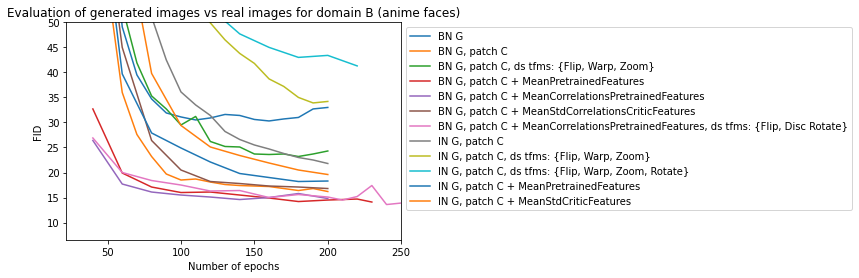

In [23]:
plot_fids_vs_epochs(fids_tr2_a2b_ema_dict, label=model_descriptions['2'])
plot_fids_vs_epochs(fids_tr2b_a2b_ema_dict, label=model_descriptions['2b'])
plot_fids_vs_epochs(fids_tr2c_a2b_ema_dict, label=model_descriptions['2c'])
plot_fids_vs_epochs(fids_tr2f_a2b_ema_dict, label=model_descriptions['2f'])
plot_fids_vs_epochs(fids_tr2h_a2b_ema_dict, label=model_descriptions['2h'])
plot_fids_vs_epochs(fids_tr2i_a2b_ema_dict, label=model_descriptions['2i'])
plot_fids_vs_epochs(fids_tr2j_a2b_ema_dict, label=model_descriptions['2j'])
plot_fids_vs_epochs(fids_tr3b_a2b_ema_dict, label=model_descriptions['3b'])
plot_fids_vs_epochs(fids_tr3c_a2b_ema_dict, label=model_descriptions['3c'])
plot_fids_vs_epochs(fids_tr3d_a2b_ema_dict, label=model_descriptions['3d'])
#plot_fids_vs_epochs(fids_tr3e_a2b_ema_dict, label=model_descriptions['3e'])
plot_fids_vs_epochs(fids_tr3f_a2b_ema_dict, label=model_descriptions['3f'])
ax=plot_fids_vs_epochs(fids_tr3g_a2b_ema_dict, label=model_descriptions['3g'])
#ax=plot_fids_vs_epochs(fids_tr4b_a2b_ema_dict, label=model_descriptions['4b'])
ax.set_ybound(None, 50)
ax.set_xbound(None, 250)
ax.set_title('Evaluation of generated images vs real images for domain B (anime faces)')
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

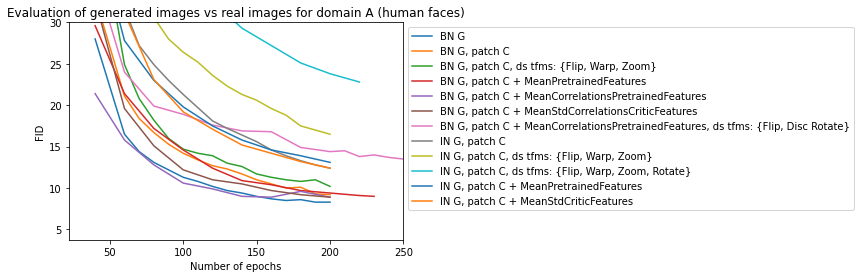

In [22]:
plot_fids_vs_epochs(fids_tr2_b2a_ema_dict, label=model_descriptions['2'])
plot_fids_vs_epochs(fids_tr2b_b2a_ema_dict, label=model_descriptions['2b'])
plot_fids_vs_epochs(fids_tr2c_b2a_ema_dict, label=model_descriptions['2c'])
plot_fids_vs_epochs(fids_tr2f_b2a_ema_dict, label=model_descriptions['2f'])
plot_fids_vs_epochs(fids_tr2h_b2a_ema_dict, label=model_descriptions['2h'])
plot_fids_vs_epochs(fids_tr2i_b2a_ema_dict, label=model_descriptions['2i'])
plot_fids_vs_epochs(fids_tr2j_b2a_ema_dict, label=model_descriptions['2j'])
plot_fids_vs_epochs(fids_tr3b_b2a_ema_dict, label=model_descriptions['3b'])
plot_fids_vs_epochs(fids_tr3c_b2a_ema_dict, label=model_descriptions['3c'])
plot_fids_vs_epochs(fids_tr3d_b2a_ema_dict, label=model_descriptions['3d'])
#plot_fids_vs_epochs(fids_tr3e_b2a_ema_dict, label=model_descriptions['3e'])
plot_fids_vs_epochs(fids_tr3f_b2a_ema_dict, label=model_descriptions['3f'])
ax=plot_fids_vs_epochs(fids_tr3g_b2a_ema_dict, label=model_descriptions['3g'])
#ax = plot_fids_vs_epochs(fids_tr4b_b2a_ema_dict, label=model_descriptions['4b'])
ax.set_ybound(None, 30)
ax.set_xbound(None, 250)
ax.set_title('Evaluation of generated images vs real images for domain A (human faces)')
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

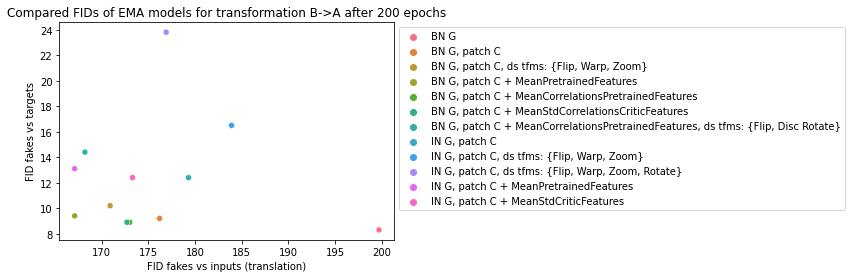

In [18]:
ax = plot_fids_vs_inputs_targets(200, 'A', use_ema_models=True, 
                                 ids_excluded=ids_excluded)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

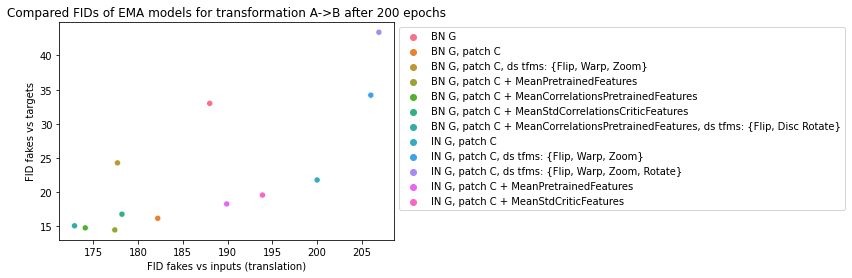

In [19]:
ax = plot_fids_vs_inputs_targets(200, 'B', use_ema_models=True,
                                 ids_excluded=ids_excluded)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

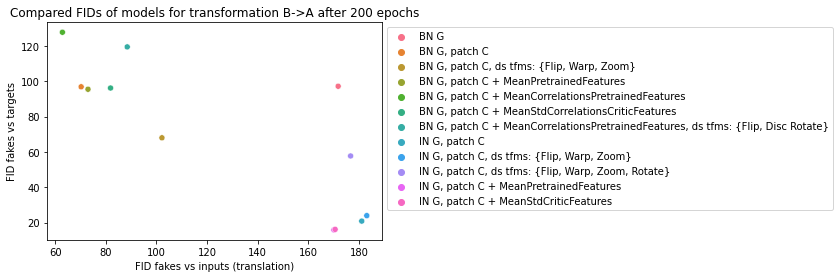

In [20]:
ax = plot_fids_vs_inputs_targets(200, 'A', use_ema_models=False,
                                ids_excluded=ids_excluded)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

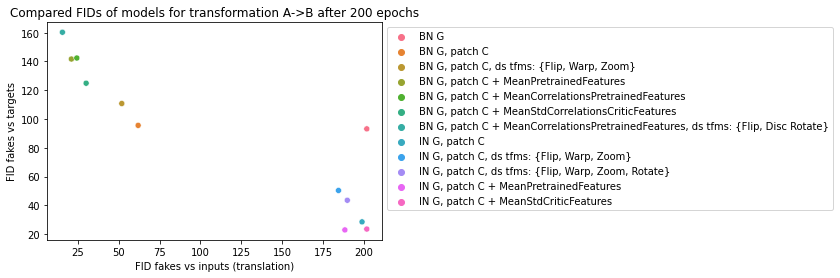

In [21]:
ax = plot_fids_vs_inputs_targets(200, 'B', use_ema_models=False, 
                                 ids_excluded=ids_excluded)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1., 1.))

# Performing evaluation

In [ ]:
base_fid_samples_path = Path('./fid_samples')
n_fid_imgs = 10000


def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

    
def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'fake/A').mkdir()
    (base_fid_samples_path/'fake/B').mkdir()
    (base_fid_samples_path/'real').mkdir()
    (base_fid_samples_path/'real/A').mkdir()
    (base_fid_samples_path/'real/B').mkdir()
    (base_fid_samples_path/'input').mkdir()
    (base_fid_samples_path/'input/A').mkdir()
    (base_fid_samples_path/'input/B').mkdir()

    
def save_real_imgs(dls, n_imgs=10000):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            in_a_t, in_b_t, _, _ = dec_b[i]
            img_a = PILImage.create(in_a_t)
            img_b = PILImage.create(in_b_t)
            img_idx = n_imgs_left-1
            img_a.save(base_fid_samples_path/f'real/A/{img_idx}.jpg')
            img_b.save(base_fid_samples_path/f'real/B/{img_idx}.jpg')
            #if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1    

            
def save_fake_imgs(learner, n_imgs=10000, max_pred_sz=5000, save_inputs=False, **predict_n_kwargs):
    base_path = base_fid_samples_path
    n_imgs_left = n_imgs
    n_chunks = math.ceil(n_imgs/max_pred_sz)
    idxs = [(i*max_pred_sz, min(n_imgs, (i+1)*max_pred_sz)) for i in range(n_chunks)]
    for ini_idx, end_idx in idxs:
        preds_batch = predict_n(learner, (ini_idx, end_idx), **predict_n_kwargs)
        for i, (in_a, in_b, img_t_a2b, img_t_b2a) in enumerate(preds_batch):
            idx = i + ini_idx
            PILImage.create(img_t_a2b).save(base_path/f'fake/B/{idx}.jpg')
            PILImage.create(img_t_b2a).save(base_path/f'fake/A/{idx}.jpg')
            if save_inputs:
                PILImage.create(in_a).save(base_path/f'input/A/{idx}.jpg')
                PILImage.create(in_b).save(base_path/f'input/B/{idx}.jpg')
        preds_batch = None
        clean_mem()

In [ ]:
!rm -R $base_fid_samples_path

In [ ]:
download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [ ]:
class FIDEvalType(Enum):
    FAKE_VS_TARGET = 1
    INPUT_VS_FAKE = 2


def exec_fid_proc(domain, eval_type):
    second_set_path = (base_fid_samples_path/'real'/domain if eval_type == FIDEvalType.FAKE_VS_TARGET 
                       else base_fid_samples_path/'input'/reverse_domain(domain))
    return subprocess.run(["python", "-m", "pytorch_fid", base_fid_samples_path/'fake'/domain, 
                           second_set_path], 
                          stdout=subprocess.PIPE)


def fid_out_to_arr(fid_proc_out):
    if isinstance(fid_proc_out, bytes):
        fid_proc_out = fid_proc_out.decode(sys.stdout.encoding)
    float_fids = [round(float(line[5:].strip()), ndigits=1) 
                  for line in fid_proc_out.split('\n') 
                  if line.startswith('FID')]
    return float_fids


def eval_models(builders, n_epochs, eval_type=FIDEvalType.FAKE_VS_TARGET, 
                base_path='./models', fn_suffix='', ema=False):
    assert is_iterable(builders) or is_iterable(n_epochs)
    if not is_iterable(builders): 
        builders = [builders] * len(list(n_epochs))
    if not is_iterable(n_epochs): 
        n_epochs = [n_epochs] * len(list(builders))
    result = {'A': [], 'B': []}
    for builder, n_ep in zip(builders, n_epochs):
        model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'face2anime_bidir_tr{model_id}{fn_suffix}_{n_ep}ep', with_opt=False,
                          base_path=base_path, with_ema=ema)
        if ema: 
            learner = Learner(learner.dls, learner.ema_model,
                              loss_func=lambda *args: torch.tensor(0.))
        save_fake_imgs(learner, n_imgs=n_fid_imgs, save_inputs=(eval_type==FIDEvalType.INPUT_VS_FAKE))
        for domain in result.keys():
            completed_proc = exec_fid_proc(domain, eval_type)
            fid_value = fid_out_to_arr(completed_proc.stdout)
            result[domain].extend(fid_value)
            print(f'---- {model_id} ({domain}), after {n_ep} epochs ----')
            print(completed_proc.stdout)
    return result

In [ ]:
save_real_imgs(dls, n_fid_imgs)

In [ ]:
eval_models(create_learner_1, range(5, 201, 5), fn_suffix='', base_path='./models')

In [ ]:
eval_models(create_learner_1, range(5, 201, 5), base_path='./models', fn_suffix='', ema=True)

In [ ]:
eval_models(create_learner_1, range(5, 201, 5), base_path='./models', fn_suffix='',
            ema=True, eval_type=FIDEvalType.INPUT_VS_FAKE)

In [ ]:
PILImage.create(base_fid_samples_path/'fake/A/10.jpg')

## Reference FID

With 10000 images:

* FID domain A ds vs itself (CelebA vs CelebA) ~ 2.8
* FID domain B ds vs itself (Animecharacterfaces vs Animecharacterfaces) ~ 4.0